In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
df = pd.read_csv("../train.csv")
df

,date,Price,Country,Price_7d,Price_14d,Price_21d,Price_28d,Price_7d_der,Price_14d_der,Price_21d_der,Price_28d_der,Month,Day,target
0,2017-12-27,0.0,Australia,0.0,6.650000e+00,6.65,19.25,0.000000,0.000,-0.119048,-1.442857,12,27,0.00
1,2017-12-28,0.0,Australia,0.0,6.650000e+00,6.65,19.25,0.000000,0.000,0.000000,0.000000,12,28,0.00
2,2017-12-29,0.0,Australia,0.0,6.650000e+00,6.65,19.25,0.000000,0.000,0.000000,0.000000,12,29,0.00
3,2017-12-30,0.0,Australia,0.0,-1.776357e-15,6.65,19.25,0.000000,-0.475,0.000000,0.000000,12,30,0.00
4,2017-12-31,0.0,Australia,0.0,-1.776357e-15,6.65,19.25,0.000000,0.000,0.000000,0.000000,12,31,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15789,2019-06-21,0.0,Unspecified,42.1,4.210000e+01,42.10,42.10,0.000000,0.000,0.000000,0.000000,6,21,219.88
15790,2019-06-22,0.0,Unspecified,42.1,4.210000e+01,42.10,42.10,0.000000,0.000,0.000000,0.000000,6,22,219.88
15791,2019-06-23,0.0,Unspecified,42.1,4.210000e+01,42.10,42.10,0.000000,0.000,0.000000,0.000000,6,23,219.88
15792,2019-06-24,0.0,Unspecified,42.1,4.210000e+01,42.10,42.10,0.000000,0.000,0.000000,0.000000,6,24,219.88


In [3]:
#find top 10 countries
train_countries = list(df.groupby("Country").agg({"Price": "sum"}).sort_values(by="Price", ascending=False).iloc[:10].index)
train_countries

['United Kingdom',
 'EIRE',
 'Germany',
 'Norway',
 'France',
 'Spain',
 'Hong Kong',
 'Portugal',
 'Singapore',
 'Netherlands']

In [25]:
country_errors = {}

Baseline: linear regression

In [26]:
linreg_dict = {}
for country in train_countries:
    country_df = df.loc[df["Country"]==country, :]
    X = country_df.loc[:, country_df.columns[3:-1]]
    y = country_df.loc[:, "target"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=2021) 
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('GBT', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    eval_rmse =  round(np.sqrt(mean_squared_error(y_valid, y_pred)))
    linreg_dict[country] = eval_rmse
    print(country + " RMSE: " + str(eval_rmse))
country_errors["LinReg"] = linreg_dict

United Kingdom RMSE: 79473
EIRE RMSE: 4740
Germany RMSE: 823
Norway RMSE: 6798
France RMSE: 1146
Spain RMSE: 758
Hong Kong RMSE: 1586
Portugal RMSE: 1109
Singapore RMSE: 3364
Netherlands RMSE: 313


In [28]:
gbt_dict = {}
for country in train_countries:
    country_df = df.loc[df["Country"]==country, :]
    X = country_df.loc[:, country_df.columns[3:-1]]
    y = country_df.loc[:, "target"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=2021) 
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('GBT', GradientBoostingRegressor())])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    eval_rmse =  round(np.sqrt(mean_squared_error(y_valid, y_pred)))
    gbt_dict[country] = eval_rmse
    print(country + " RMSE: " + str(eval_rmse))
country_errors["GBT"] = gbt_dict

United Kingdom RMSE: 37151
EIRE RMSE: 2543
Germany RMSE: 382
Norway RMSE: 3535
France RMSE: 647
Spain RMSE: 240
Hong Kong RMSE: 893
Portugal RMSE: 538
Singapore RMSE: 47
Netherlands RMSE: 147


In [29]:
adaboost_dict = {}
for country in train_countries:
    country_df = df.loc[df["Country"]==country, :]
    X = country_df.loc[:, country_df.columns[3:-1]]
    y = country_df.loc[:, "target"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=2021) 
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('GP', AdaBoostRegressor(n_estimators=150))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    eval_rmse =  round(np.sqrt(mean_squared_error(y_valid, y_pred)))
    adaboost_dict[country] = eval_rmse
    print(country + " RMSE: " + str(eval_rmse))
country_errors["AdaBoost"] = adaboost_dict

United Kingdom RMSE: 35397
EIRE RMSE: 3053
Germany RMSE: 466
Norway RMSE: 2802
France RMSE: 934
Spain RMSE: 365
Hong Kong RMSE: 1048
Portugal RMSE: 755
Singapore RMSE: 60
Netherlands RMSE: 227


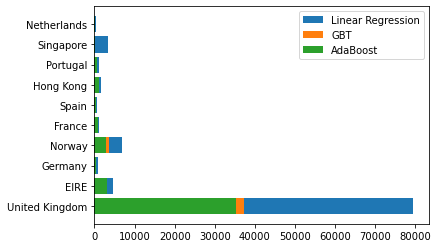

In [38]:
plt.barh(range(len(country_errors["LinReg"].keys())), country_errors["LinReg"].values(), label="Linear Regression")
plt.barh(range(len(country_errors["GBT"].keys())), country_errors["GBT"].values(), label="GBT")
plt.barh(range(len(country_errors["AdaBoost"].keys())), country_errors["AdaBoost"].values(), label="AdaBoost")
plt.yticks(range(len(country_errors["LinReg"].keys())), country_errors["LinReg"].keys())
plt.legend()
plt.show()

Our chosen model perform indeed much better than baseline on all countries.